In [102]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from pandas.tseries.offsets import DateOffset

import warnings
import seaborn as sns 
from itertools import cycle
import matplotlib.pyplot as plt


%matplotlib inline 
plt.style.use('bmh')
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
warnings.filterwarnings("ignore")
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [3]:
data = pd.read_csv(
    "SoleaTimeSeriesDataset-Temperature-Salinity.csv",
    usecols=["id","year_month","obs_id","salinitySurface"]
    )

In [4]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70320 entries, 0 to 70319
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               70320 non-null  object 
 1   obs_id           70320 non-null  int64  
 2   year_month       70320 non-null  object 
 3   salinitySurface  70320 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.1+ MB


In [5]:
data.head()

,id,obs_id,year_month,salinitySurface
0,02008-01,0,2008-01,37.147140
1,02008-02,0,2008-02,37.084457
2,02008-03,0,2008-03,36.935814
3,02008-04,0,2008-04,37.155983
4,02008-05,0,2008-05,37.341560


In [6]:
data.shape

(70320, 4)

In [7]:
data['year_month'] = pd.to_datetime(data['year_month'])

In [8]:
data['month'] = data['year_month'].dt.month
data['year'] = data['year_month'].dt.year


In [9]:
data.set_index('year_month',inplace=True)

In [10]:
data[data['obs_id']==2]['salinitySurface']

year_month
2008-01-01    38.059185
2008-02-01    37.981125
2008-03-01    38.007427
2008-04-01    37.915913
2008-05-01    37.992910
                ...    
2017-08-01    38.097942
2017-09-01    38.249940
2017-10-01    37.950560
2017-11-01    38.234016
2017-12-01    38.526005
Name: salinitySurface, Length: 120, dtype: float64

In [11]:
dataSal = data[data['obs_id'] == 2]['salinitySurface']
dataSal.index.freq = 'MS'

In [12]:
# dataSal

In [13]:
train_data = dataSal.iloc[:96]
test_data = dataSal.iloc[96:]

In [42]:
span = 12 
alpha = 2/(span+1)
simpleExpSmooth_model = SimpleExpSmoothing(train_data.values).fit(smoothing_level=alpha,optimized=False)
doubleExpSmooth_model = ExponentialSmoothing(train_data.values,trend='add',seasonal_periods=12).fit()
tripleExpSmooth_model = ExponentialSmoothing(train_data.values,trend='add',seasonal='add',seasonal_periods=12).fit()

In [43]:
predictions_simpleExpSmooth_model = simpleExpSmooth_model.forecast(24)
predictions_doubleExpSmooth_model = doubleExpSmooth_model.forecast(24)
predictions_tripleExpSmooth_model = tripleExpSmooth_model.forecast(24)

<AxesSubplot: xlabel='year_month'>

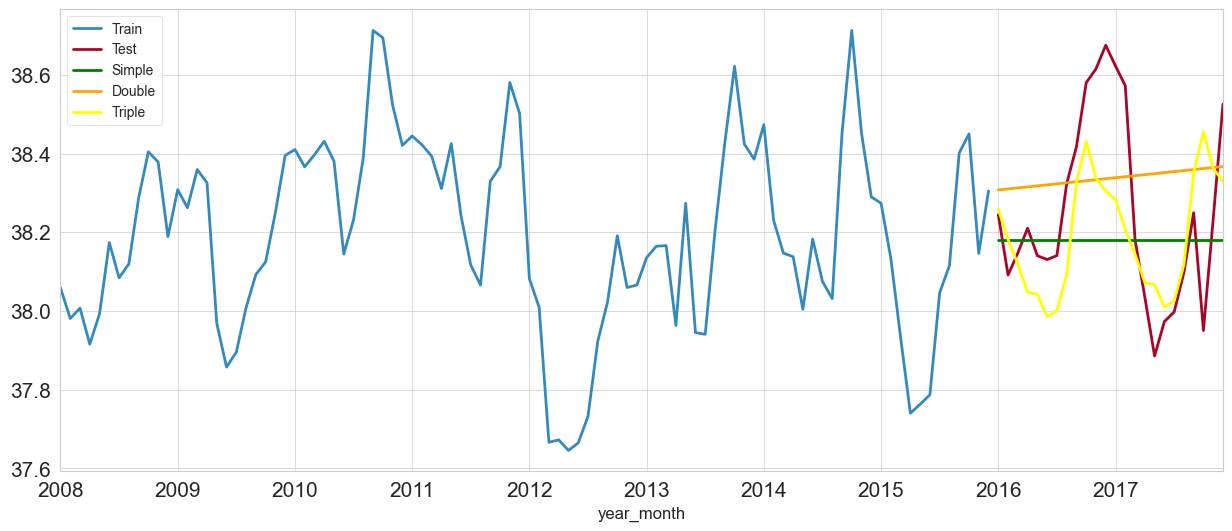

In [56]:
plt.figure(figsize=(15,6))
train_data.plot(legend=True,label='Train')
test_data.plot(legend=True,label='Test')
pd.Series(predictions_simpleExpSmooth_model,index=test_data.index).plot(legend=True,label='Simple',c='green')
pd.Series(predictions_doubleExpSmooth_model,index=test_data.index).plot(legend=True,label='Double',c='orange')
pd.Series(predictions_tripleExpSmooth_model,index=test_data.index).plot(legend=True,label='Triple',c='yellow')


In [61]:
# RMSE
expo_smooth = {"simple":predictions_simpleExpSmooth_model,"double":predictions_doubleExpSmooth_model,"triple":predictions_tripleExpSmooth_model}
for typ,val in expo_smooth.items():
    print(f"{typ}: {np.sqrt(mean_squared_error(test_data,val))}")


simple: 0.2423042045208137
double: 0.2490567609937009
triple: 0.2032951022376803


In [63]:
test_data.std()

0.23664050411795723

In [123]:
plt.axvline?

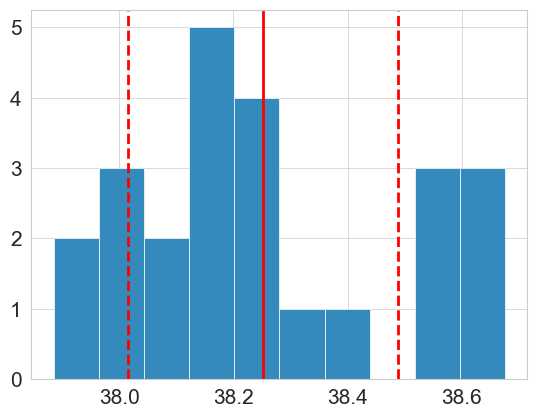

In [125]:
plt.hist(test_data)
plt.axvline(test_data.mean(),c='red',label='Standard Deviation')
plt.axvline(test_data.mean() + test_data.std() ,c='red',label='Standard Deviation',ls='--')
plt.axvline(test_data.mean() - test_data.std() ,c='red',label='Standard Deviation',ls='--')

In [78]:
model = ExponentialSmoothing(dataSal.values,
                             trend='add',
                             seasonal='add',
                             seasonal_periods=12
)

results = model.fit()
fcast = results.predict(len(dataSal),len(dataSal)+12)

In [118]:
fcast_df = pd.Series(
        fcast,
        index=pd.date_range(
        start=dataSal.index[-1] + DateOffset(months=1),
    #     end=dataSal.index[-1] + DateOffset(months=13),
        freq='MS',
        periods=13
    )
)

In [98]:
# dataSal.index[-1].strftime('%Y-%m-%d')

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Salinity')]

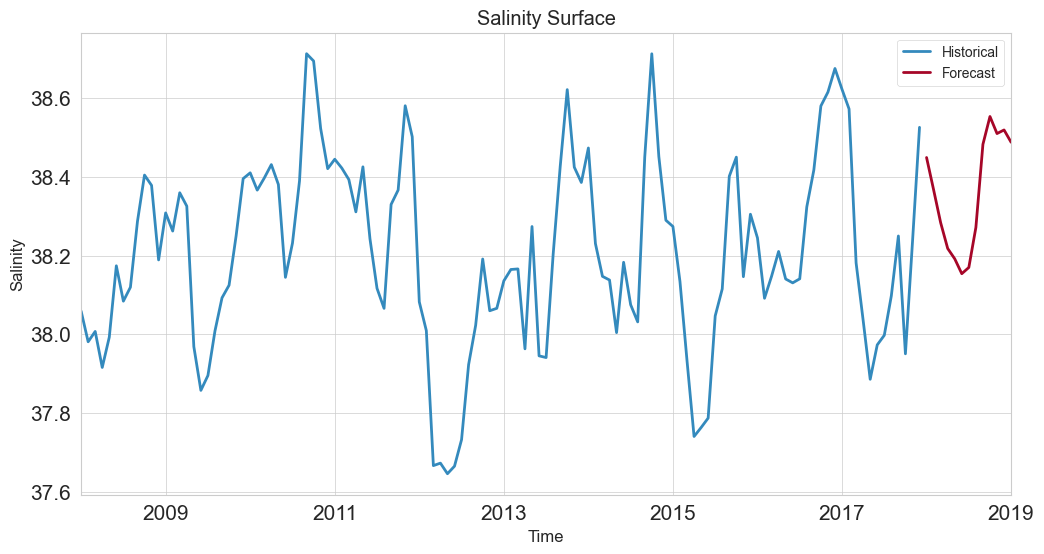

In [120]:
ax = dataSal.plot(legend=True,figsize=(12,6),title='Salinity Surface',label='Historical')
fcast_df.plot(legend=True,label='Forecast')

ax.autoscale(axis='x',tight=True)
ax.set(xlabel='Time',ylabel='Salinity')